<img src="https://qs.topuniversities.com/hs-fs/hubfs/07_HumanScience_H_300.jpg?width=4961&height=3508&name=07_HumanScience_H_300.jpg\" width="180" height="120"  />



#### F. Gerardo Gandara Espinosa
June 12, 2021

### This book is just an improvement in the machine learning model. 

> Please reference to the github repository for the full credit


> https://github.com/miguel-angel-monjas/uetrajectories/blob/master/sources/ue_mobility.ipynb






# UE mobility prediction

The UE connects via a DN to the closest application server. Next, it moves to the next edge site. To keep latency low after a gNB handover, the UE’s context should be relocated not only on the gNB, but also on the UPF and the application server.

If the network knows in advance that the UE will move to the target edge site, then some parts of the relocation procedure can be done before the actual gNB handover. In this way, the overall procedure is shortened, and the handover can be performed more smoothly.


<div>
<img src="https://i.postimg.cc/tJHj5fVN/image.png" width="400">
</div>

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (10, 5)

## Data analysis

The dataset in `trajectories.json.gz` is made of events carrying the following features:
* `currentEnb`: gNB the user has moved to 
* `eventId`: type of event
* `imsi`: IMSI (user identifier) the event belongs to. 
* `timestamp`: minutes starting from 0 at day 1 in the dataset. The dataset contains data from about four days and a half 
* `timeSlot`: a 15-minute slot generated from timestamp. There should be 96 timeslots in a day. `timeSlot` is restarted every day. 

## Exploratory Data Analysis

In [44]:
df = pd.read_json('gdrive/MyDrive/Colab Notebooks/Telecom/MobilityPredictor/sources/trajectories.json.gz', compression='gzip')
df.head()

,currentEnb,eventId,imsi,timeSlot,timestamp
0,22,12,2778514794,0,0
1,16,12,2793518354,0,0
2,37,12,2793522274,0,0
3,15,12,2781330414,0,0
4,18,12,2793525404,0,0


In [45]:
df.describe()

,currentEnb,eventId,imsi,timeSlot,timestamp
count,479154.000000,479154.0,4.791540e+05,479154.000000,479154.000000
mean,22.057887,12.0,2.788115e+09,24.752558,3127.615489
std,11.116315,0.0,5.528592e+06,24.060522,2094.975400
min,0.000000,12.0,2.778515e+09,0.000000,0.000000
25%,11.000000,12.0,2.783141e+09,1.000000,1450.000000
50%,24.000000,12.0,2.788265e+09,4.000000,2914.000000
75%,32.000000,12.0,2.792899e+09,49.000000,5055.000000
max,40.000000,12.0,2.797493e+09,55.000000,6587.000000


In [46]:
df.nunique()

currentEnb      41
eventId          1
imsi          8687
timeSlot        15
timestamp     1036
dtype: int64

In [47]:
df.head(5)

,currentEnb,eventId,imsi,timeSlot,timestamp
0,22,12,2778514794,0,0
1,16,12,2793518354,0,0
2,37,12,2793522274,0,0
3,15,12,2781330414,0,0
4,18,12,2793525404,0,0


In [48]:
df[df['imsi'] == 2785554734]

,currentEnb,eventId,imsi,timeSlot,timestamp
5677,29,12,2785554734,0,0
10037,30,12,2785554734,0,2
30897,3,12,2785554734,1,20
39450,31,12,2785554734,1,29
40386,3,12,2785554734,2,30
...,...,...,...,...,...
479146,29,12,2785554734,54,6580
479149,30,12,2785554734,54,6581
479150,29,12,2785554734,54,6582
479151,30,12,2785554734,54,6583


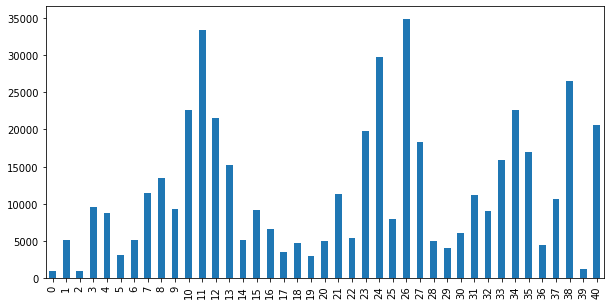

In [49]:
df['currentEnb'].value_counts().sort_index().plot(kind='bar')

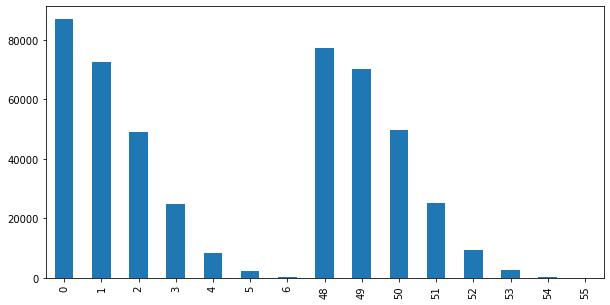

In [50]:
df['timeSlot'].value_counts().sort_index().plot(kind='bar')

In [51]:
df['timestamp'].max()

6587

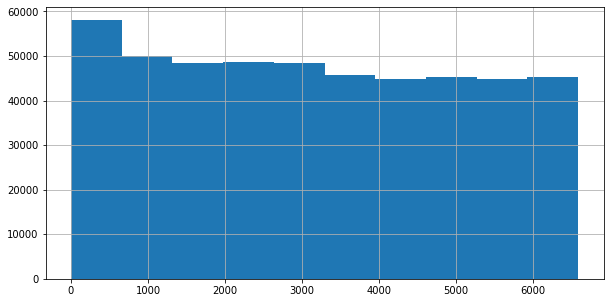

In [52]:
df['timestamp'].hist(bins=10)

### Additional data sources

For each gNodeB, `topology_neighbours.json` contains its closest neighbours.

In [53]:
gnb_neigh = pd.read_json('gdrive/MyDrive/Colab Notebooks/Telecom/MobilityPredictor/sources/topology_neighbours.json', orient='index')
gnb_neigh.reset_index(inplace=True)
gnb_neigh.columns = ['gnodeB', 'neigh_1', 'neigh_2', 'neigh_3', 'neigh_4']
gnb_neigh.head()

,gnodeB,neigh_1,neigh_2,neigh_3,neigh_4
0,0,5,2,16,4
1,29,1,30,5,3
2,5,1,0,2,4
3,1,5,29,4,3
4,3,31,1,8,30


## Feature engineering

First, we select the first day as train set.

In [54]:
day_1 = df.loc[(df['timestamp']>=0) & (df['timestamp']<1440)]
day_2 = df.loc[(df['timestamp']>=1440) & (df['timestamp']<2880)]

For each mobility event, we create a number of new features:
* `stay_time`: time until the same user moves to another gNodeB (and thus a new event is received).
* `transit_time`: time it took the user to move from the the previous gNodeB. For a same user that goes from gNodeB-a to gNodeB-b, `stay_time` in gNodeB-A is the same as `transit_time` in gNodeB-b
* `transition_slot`: bucketed `transit_time` considering that any time greater than 60 minutes is assigned 100 minutes.
* `time_of_day`: bucketed `timeSlot` (five periods of time in the day).

In [55]:
grouped_df = day_1.set_index(['imsi', 'timestamp']).sort_index().reset_index()
grouped_df['next_timestamp'] = grouped_df.groupby(['imsi'])['timestamp'].shift(-1)
grouped_df['prev_timestamp'] = grouped_df.groupby(['imsi'])['timestamp'].shift(1)
grouped_df['stay_time'] = grouped_df['next_timestamp'] - grouped_df['timestamp']
grouped_df['transit_time'] = grouped_df['timestamp'] - grouped_df['prev_timestamp']

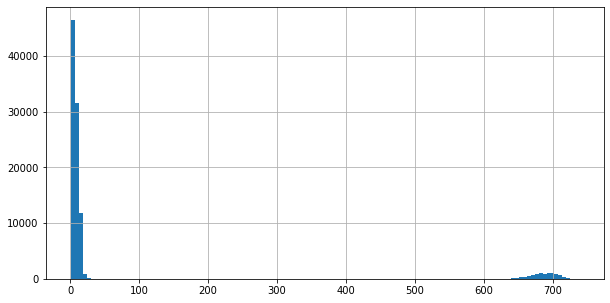

In [56]:
grouped_df['stay_time'].hist(bins=128)

See the peak around 700 minutes, that could correspond to people remaining at work for such period of time.

In [57]:
grouped_df['transit_time'].max()

737.0

In [58]:
max_transit_time = grouped_df['transit_time'].max()
grouped_df['transition_slot'] = pd.cut(grouped_df['transit_time'], 
                                       [0, 1, 5, 15, 30, 60, max_transit_time],
                                       labels=[1, 5, 15, 30, 60, 100])
grouped_df['transition_slot'].value_counts().sort_index()

1      25608
5      17234
15     43919
30      4085
60         0
100     8634
Name: transition_slot, dtype: int64

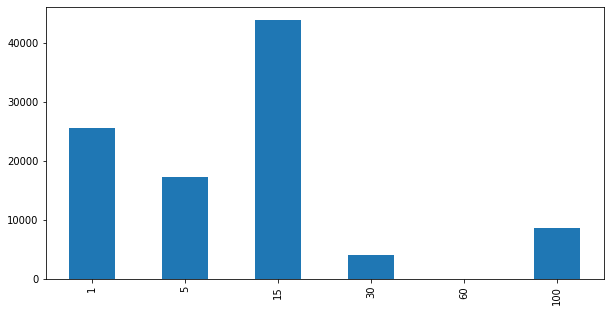

In [59]:
grouped_df['transition_slot'].value_counts().sort_index().plot(kind='bar')

Five equal bins are defined.

In [60]:
grouped_df['time_of_day'] = pd.cut(grouped_df['timeSlot'],
                                   bins=5,
                                   labels=['early_morn', 'morning', 'noon', 'evening', 'night'])

In [61]:
#grouped_df['time_of_day'].value_counts().reindex(index=['early_morn', 'morning', 'noon', 'evening', 'night'])

In [62]:
#grouped_df['time_of_day'].value_counts().reindex(index=['early_morn', 'morning', 'noon', 'evening', 'night']).plot(kind='bar')

`ue_home_df` records how long a given user is at a given gNodeB (from `stay_time`)

In [63]:
ue_home_df = grouped_df.groupby(['imsi', 'currentEnb'])['stay_time'].sum().reset_index()
ue_home_df.head()

,imsi,currentEnb,stay_time
0,2778514794,6,8.0
1,2778514794,9,2.0
2,2778514794,13,2.0
3,2778514794,18,8.0
4,2778514794,21,11.0


`home_df` records the gNodeB where each user stays for longer

In [64]:
home_gnb = ue_home_df.loc[ue_home_df.groupby(['imsi'])['stay_time'].idxmax()][['imsi', 'currentEnb']]
home_gnb.columns = ['imsi', 'home_gnb']
home_gnb.head()

,imsi,home_gnb
8,2778514794,40
12,2778531564,27
21,2778535004,38
22,2778540704,7
30,2778543964,26


`ue_df` records the number of gNodeB's a given user is in for each time of the day

In [65]:
ue_df = grouped_df.groupby(['imsi', 'time_of_day'])['currentEnb'].count().reset_index()
ue_df.head()

,imsi,time_of_day,currentEnb
0,2778514794,early_morn,8
1,2778514794,morning,0
2,2778514794,noon,0
3,2778514794,evening,0
4,2778514794,night,4


`ue_ctxt_df` contains the same information than `ue_df` but pivotted to show a user per row

In [66]:
ue_ctxt_df = pd.pivot_table(ue_df, index='imsi', columns='time_of_day', values='currentEnb', fill_value=0)
ue_ctxt_df.head()

time_of_day,early_morn,morning,noon,evening,night
imsi,,,,,
2778514794,8,0,0,0,4
2778531564,4,0,0,0,6
2778535004,5,0,0,0,7
2778540704,5,0,0,0,5
2778543964,3,0,0,0,9


`seq_df` is an auxiliary dataframe that, for each user, provides its trajectory, the time where each transition happened, the bucketed time it took for each user to move from the previous gNodeB and the signal strength in each gNodeB

In [67]:
seq_df = grouped_df.groupby(['imsi'])['currentEnb', 'timeSlot','transition_slot'] \
                   .agg(lambda x: list(x)).reset_index()

seq_df.head()

,imsi,currentEnb,timeSlot,transition_slot
0,2778514794,"[22, 18, 9, 23, 13, 23, 13, 40, 6, 21, 22, 39]","[0, 0, 1, 1, 2, 2, 2, 2, 48, 49, 49, 50]","[nan, 15, 15, 5, 15, 1, 1, 1, 100, 15, 15, 15]"
1,2778531564,"[10, 11, 26, 27, 38, 26, 38, 26, 34, 10]","[0, 0, 1, 1, 48, 49, 49, 49, 49, 50]","[nan, 5, 15, 15, 100, 15, 1, 1, 5, 15]"
2,2778535004,"[17, 15, 32, 35, 38, 26, 38, 35, 32, 15, 14, 17]","[0, 0, 0, 1, 1, 48, 48, 48, 49, 49, 49, 50]","[nan, 5, 15, 15, 15, 100, 1, 5, 15, 5, 15, 5]"
3,2778540704,"[35, 38, 26, 27, 7, 27, 24, 26, 38, 35]","[0, 0, 0, 1, 2, 48, 48, 49, 49, 50]","[nan, 5, 15, 5, 30, 100, 5, 15, 15, 5]"
4,2778543964,"[7, 24, 26, 27, 24, 27, 24, 27, 24, 27, 24, 7]","[0, 0, 1, 48, 48, 48, 48, 48, 48, 48, 49, 49]","[nan, 5, 15, 100, 1, 1, 1, 1, 1, 1, 1, 5]"


In [68]:
def window_sequence(seq, window_size=5):
    """This function turns a sequence intro 
    a matrix where each row is a sequence of
    the previous 'windows_size' elements"""
    
    windows = []
    seq_len = len(seq)
    for i in range(len(seq) - window_size + 1):
        window = []
        for j in range(i, i + window_size):
            window.append(seq[j])
        windows.append(window)
    return windows

Each feature in `seq_df` creates a new feature where the sequences from the original feature is recorded (five elements in each sequence):
* `gnode_seq` records the sequences of each gNodeB in `currentEnb`.
* `time_seq` records the sequences of each timeslots in `timeSlot`.
* `trans_seq` records the sequences of each transition slots in `transition_slot`.

Additionally, we create a new feature with the number of transitions:
* `seq_len`

In [69]:
seq_df['gnode_seq'] = seq_df['currentEnb'].apply(window_sequence).values
seq_df['time_seq'] = seq_df['timeSlot'].apply(window_sequence).values
seq_df['trans_seq'] = seq_df['transition_slot'].apply(window_sequence).values
seq_df['seq_len'] = seq_df['gnode_seq'].apply(lambda x: len(x))
seq_df

,imsi,currentEnb,timeSlot,transition_slot,gnode_seq,time_seq,trans_seq,seq_len
0,2778514794,"[22, 18, 9, 23, 13, 23, 13, 40, 6, 21, 22, 39]","[0, 0, 1, 1, 2, 2, 2, 2, 48, 49, 49, 50]","[nan, 15, 15, 5, 15, 1, 1, 1, 100, 15, 15, 15]","[[22, 18, 9, 23, 13], [18, 9, 23, 13, 23], [9,...","[[0, 0, 1, 1, 2], [0, 1, 1, 2, 2], [1, 1, 2, 2...","[[nan, 15, 15, 5, 15], [15, 15, 5, 15, 1], [15...",8
1,2778531564,"[10, 11, 26, 27, 38, 26, 38, 26, 34, 10]","[0, 0, 1, 1, 48, 49, 49, 49, 49, 50]","[nan, 5, 15, 15, 100, 15, 1, 1, 5, 15]","[[10, 11, 26, 27, 38], [11, 26, 27, 38, 26], [...","[[0, 0, 1, 1, 48], [0, 1, 1, 48, 49], [1, 1, 4...","[[nan, 5, 15, 15, 100], [5, 15, 15, 100, 15], ...",6
2,2778535004,"[17, 15, 32, 35, 38, 26, 38, 35, 32, 15, 14, 17]","[0, 0, 0, 1, 1, 48, 48, 48, 49, 49, 49, 50]","[nan, 5, 15, 15, 15, 100, 1, 5, 15, 5, 15, 5]","[[17, 15, 32, 35, 38], [15, 32, 35, 38, 26], [...","[[0, 0, 0, 1, 1], [0, 0, 1, 1, 48], [0, 1, 1, ...","[[nan, 5, 15, 15, 15], [5, 15, 15, 15, 100], [...",8
3,2778540704,"[35, 38, 26, 27, 7, 27, 24, 26, 38, 35]","[0, 0, 0, 1, 2, 48, 48, 49, 49, 50]","[nan, 5, 15, 5, 30, 100, 5, 15, 15, 5]","[[35, 38, 26, 27, 7], [38, 26, 27, 7, 27], [26...","[[0, 0, 0, 1, 2], [0, 0, 1, 2, 48], [0, 1, 2, ...","[[nan, 5, 15, 5, 30], [5, 15, 5, 30, 100], [15...",6
4,2778543964,"[7, 24, 26, 27, 24, 27, 24, 27, 24, 27, 24, 7]","[0, 0, 1, 48, 48, 48, 48, 48, 48, 48, 49, 49]","[nan, 5, 15, 100, 1, 1, 1, 1, 1, 1, 1, 5]","[[7, 24, 26, 27, 24], [24, 26, 27, 24, 27], [2...","[[0, 0, 1, 48, 48], [0, 1, 48, 48, 48], [1, 48...","[[nan, 5, 15, 100, 1], [5, 15, 100, 1, 1], [15...",8
...,...,...,...,...,...,...,...,...
8629,2797485664,"[33, 34, 35, 38, 37, 38, 35, 34, 33]","[0, 0, 0, 1, 1, 1, 48, 48, 49]","[nan, 15, 5, 15, 1, 1, 100, 15, 15]","[[33, 34, 35, 38, 37], [34, 35, 38, 37, 38], [...","[[0, 0, 0, 1, 1], [0, 0, 1, 1, 1], [0, 1, 1, 1...","[[nan, 15, 5, 15, 1], [15, 5, 15, 1, 1], [5, 1...",5
8630,2797487414,"[38, 26, 11, 24, 13, 24, 13, 24, 40, 24, 27, 2...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 48, 48, 49, 49]","[nan, 5, 15, 15, 1, 1, 1, 1, 5, 100, 15, 5, 5]","[[38, 26, 11, 24, 13], [26, 11, 24, 13, 24], [...","[[0, 0, 0, 1, 1], [0, 0, 1, 1, 1], [0, 1, 1, 1...","[[nan, 5, 15, 15, 1], [5, 15, 15, 1, 1], [15, ...",9
8631,2797489164,"[10, 11, 13, 24, 11, 10]","[0, 0, 0, 0, 48, 49]","[nan, 1, 15, 5, 100, 15]","[[10, 11, 13, 24, 11], [11, 13, 24, 11, 10]]","[[0, 0, 0, 0, 48], [0, 0, 0, 48, 49]]","[[nan, 1, 15, 5, 100], [1, 15, 5, 100, 15]]",2
8632,2797490924,"[15, 33, 34, 26, 38, 27, 38, 27, 37, 35, 32, 15]","[0, 0, 0, 1, 2, 2, 2, 2, 48, 49, 50, 50]","[nan, 5, 15, 15, 15, 5, 1, 1, 100, 30, 15, 5]","[[15, 33, 34, 26, 38], [33, 34, 26, 38, 27], [...","[[0, 0, 0, 1, 2], [0, 0, 1, 2, 2], [0, 1, 2, 2...","[[nan, 5, 15, 15, 15], [5, 15, 15, 15, 5], [15...",8


Next, we transform each sequence feature into a new dataframe

In [70]:
enode_seq_list = [sequence for sequences in seq_df['gnode_seq'] for sequence in sequences]
time_seq_list = [sequence for sequences in seq_df['time_seq'] for sequence in sequences]
trans_seq_list = [sequence for sequences in seq_df['trans_seq'] for sequence in sequences]

enode_df = pd.DataFrame(enode_seq_list, columns=['gnode_1', 'gnode_2', 'gnode_3', 'gnode_4', 'target_gnb'])
time_df = pd.DataFrame(time_seq_list, columns=['time_1', 'time_2', 'time_3', 'time_4', 'target_time'])
trans_df = pd.DataFrame(trans_seq_list, columns=['trans_1', 'trans_2', 'trans_3', 'trans_4', 'target_trans_slot'])

In [71]:
imsi_list = list()
for a, b in zip(seq_df['imsi'], seq_df['seq_len']):
    imsi_list.extend([a] * b)

Finally, we create the dataset that will be used for prediction. What we want to predict is what follows: given a detected transition to a given gNodeB, which will be the following gNodeB and when will it happen?

Thus, the targets are:
* `target_gnb`: Next gNodeB
* `target_trans_slot`: Time it will take to move to the next gNodeB.

The following features will be considered:
* `enode_1`: The fourth previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `enode_2`: The third previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `enode_3`: The second previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `enode_4`: The first previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `time_1`: The time where the user moved to the fourth previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `time_2`: The time where the user moved to the third previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `time_3`: The time where the user moved to the second previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `time_4`: The time where the user moved to the first previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `home_gnb`: The gNodeB where the user doing for a given trajectory stays more times within a day. It's is a historical data.
* `early_morn`: The number of gNodeB's where the user for a given trajectory stays in the early morning. It's is a historical data.
* `morning`: The number of gNodeB's where the user for a given trajectory stays in the morning. It's is a historical data.
* `noon`: The number of gNodeB's where the user for a given trajectory stays at noon. It's is a historical data.
* `evening`: The number of gNodeB's where the user for a given trajectory stays in the evening. It's is a historical data.
* `night`: The number of gNodeB's where the user for a given trajectory stays at night. It's is a historical data.
* `neigh_1`: One of the four closest gNodeB's to `enode_4`. It's is a static data.
* `neigh_2`: One of the four closest gNodeB's to `enode_4`. It's is a static data.
* `neigh_3`: One of the four closest gNodeB's to `enode_4`. It's is a static data.
* `neigh_4`: One of the four closest gNodeB's to `enode_4`. It's is a static data.

In [72]:
X_train = pd.concat([enode_df, time_df], axis=1)
X_train['target_trans_slot'] = trans_df['target_trans_slot']
X_train['imsi'] = imsi_list

In [73]:
X_train = X_train.merge(home_gnb, on='imsi').merge(ue_ctxt_df, on='imsi')

In [74]:
X_train = X_train.merge(gnb_neigh, left_on='gnode_4', right_on='gnodeB', how='left')

In [75]:
del X_train['gnodeB']

In [76]:
X_train.dropna(inplace=True)
X_train

,gnode_1,gnode_2,gnode_3,gnode_4,target_gnb,time_1,time_2,time_3,time_4,target_time,target_trans_slot,imsi,home_gnb,early_morn,morning,noon,evening,night,neigh_1,neigh_2,neigh_3,neigh_4
0,22,18,9,23,13,0,0,1,1,2,15,2778514794,40,8,0,0,0,4,21,6,13,9
1,18,9,23,13,23,0,1,1,2,2,1,2778514794,40,8,0,0,0,4,11,23,24,40
2,9,23,13,23,13,1,1,2,2,2,1,2778514794,40,8,0,0,0,4,21,6,13,9
3,23,13,23,13,40,1,2,2,2,2,1,2778514794,40,8,0,0,0,4,11,23,24,40
4,13,23,13,40,6,2,2,2,2,48,100,2778514794,40,8,0,0,0,4,25,6,24,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73573,34,26,24,27,24,0,0,1,1,1,1,2797492664,24,6,0,0,0,4,24,7,26,38
73574,26,24,27,24,26,0,1,1,1,48,100,2797492664,24,6,0,0,0,4,40,13,27,26
73575,24,27,24,26,11,1,1,1,48,48,5,2797492664,24,6,0,0,0,4,11,38,34,24
73576,27,24,26,11,34,1,1,48,48,49,15,2797492664,24,6,0,0,0,4,13,26,34,10


In [77]:
y_train = X_train[['target_gnb', 'target_trans_slot']]
y_train

,target_gnb,target_trans_slot
0,13,15
1,23,1
2,13,1
3,40,1
4,6,100
...,...,...
73573,24,1
73574,26,100
73575,11,5
73576,34,15


In [78]:
to_drop_cols = ['target_gnb',
                'target_trans_slot',
                'target_time',
                'imsi'
               ]
X_train.drop(columns=to_drop_cols, axis=1, inplace=True)
X_train

,gnode_1,gnode_2,gnode_3,gnode_4,time_1,time_2,time_3,time_4,home_gnb,early_morn,morning,noon,evening,night,neigh_1,neigh_2,neigh_3,neigh_4
0,22,18,9,23,0,0,1,1,40,8,0,0,0,4,21,6,13,9
1,18,9,23,13,0,1,1,2,40,8,0,0,0,4,11,23,24,40
2,9,23,13,23,1,1,2,2,40,8,0,0,0,4,21,6,13,9
3,23,13,23,13,1,2,2,2,40,8,0,0,0,4,11,23,24,40
4,13,23,13,40,2,2,2,2,40,8,0,0,0,4,25,6,24,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73573,34,26,24,27,0,0,1,1,24,6,0,0,0,4,24,7,26,38
73574,26,24,27,24,0,1,1,1,24,6,0,0,0,4,40,13,27,26
73575,24,27,24,26,1,1,1,48,24,6,0,0,0,4,11,38,34,24
73576,27,24,26,11,1,1,48,48,24,6,0,0,0,4,13,26,34,10


In [79]:
X_train.describe()

,gnode_1,gnode_2,gnode_3,gnode_4,time_1,time_2,time_3,time_4,home_gnb,early_morn,morning,noon,evening,night,neigh_1,neigh_2,neigh_3,neigh_4
count,73578.000000,73578.000000,73578.000000,73578.000000,73578.000000,73578.000000,73578.000000,73578.000000,73578.000000,73578.000000,73578.0,73578.0,73578.0,73578.000000,73578.000000,73578.000000,73578.000000,73578.000000
mean,21.537389,21.673612,21.782122,21.617059,13.459200,17.666857,22.727242,28.350023,26.027454,8.907051,0.0,0.0,0.0,7.965384,20.745590,23.176683,23.585555,23.506986
std,11.155880,11.233333,11.148808,11.157474,20.962248,22.670749,23.634412,23.495408,10.535686,4.680869,0.0,0.0,0.0,4.563069,11.671747,11.603954,10.394676,11.988814
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.000000
25%,11.000000,11.000000,11.000000,11.000000,0.000000,1.000000,1.000000,2.000000,24.000000,6.000000,0.0,0.0,0.0,5.000000,11.000000,12.000000,15.000000,11.000000
50%,24.000000,24.000000,24.000000,24.000000,1.000000,2.000000,3.000000,48.000000,27.000000,8.000000,0.0,0.0,0.0,7.000000,18.000000,24.000000,26.000000,24.000000
75%,32.000000,33.000000,33.000000,33.000000,48.000000,48.000000,49.000000,49.000000,37.000000,11.000000,0.0,0.0,0.0,10.000000,34.000000,33.000000,34.000000,34.000000
max,40.000000,40.000000,40.000000,40.000000,54.000000,54.000000,54.000000,54.000000,40.000000,40.000000,0.0,0.0,0.0,35.000000,40.000000,39.000000,40.000000,40.000000


In [80]:
X_train['early_morn'].nunique()

36

# Function to calculate the Accuracy and the Proba-Accuracy

In [81]:
import numpy as np

def compute_accuracy(y, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=['target_gnb', 'target_trans_slot'])
    gnb_pred_acc = (sum(y.target_gnb.values == y_pred.target_gnb.values) / len(y)) * 100
    timeslot_pred_acc = (sum(y.target_trans_slot.values == y_pred.target_trans_slot.values) / len(y)) * 100
    pred_accuracy = (sum((y.target_gnb.values == y_pred.target_gnb.values) &
                            (y.target_trans_slot.values == y_pred.target_trans_slot.values)) / len(y)) * 100
    return {
        "predictionAccuracy": pred_accuracy,
        "predictionTimeSlotAccuracy": timeslot_pred_acc,
        "predictionGnodeBAccuracy": gnb_pred_acc
    }

def topk_accuracy(actual_labels, pred_gnb, pred_time, k=3):
    actual_labels_size = len(actual_labels['target_gnb'])
    predictions_size = len(pred_gnb)
    if actual_labels_size != predictions_size:
        raise ValueError("actual and predicted should be of same size")
    results = np.zeros(actual_labels_size)
    for i in range(actual_labels_size):
        if ((actual_labels['target_gnb'][i] in set(pred_gnb[i][:k])) & (actual_labels['target_trans_slot'][i] in set(pred_time[i][:k]))):
            results[i] = 1
    result = results.sum()/actual_labels_size
    print(f"predictionAccuracy with first {k} results: {result}")
    return result

## Model training

> This is the Original Model




In [158]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=30,
                               min_samples_leaf=2,
                               min_samples_split=2,
                               max_depth=15,
                               oob_score=True,
                               random_state=44)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=30,
                       oob_score=True, random_state=44)

In [159]:
y_pred = model.predict(X_train)
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 69.45962108238875,
 'predictionGnodeBAccuracy': 81.11391992171573,
 'predictionTimeSlotAccuracy': 82.74076490255239}

In [65]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
#print("X_test:", X_test.shape)
#print("y_test:", y_test.shape)

X_train: (73578, 18)
y_train: (73578, 2)


# Evaluating 5 classifiers with multiple output
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

DecisionTreeClassifier

In [70]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 95.0501508603115,
 'predictionGnodeBAccuracy': 97.08064910707004,
 'predictionTimeSlotAccuracy': 97.325287450053}

ExtraTreeClassifier

In [74]:
model = ExtraTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = compute_accuracy(y_train, y_pred)
accuracy


{'predictionAccuracy': 95.0501508603115,
 'predictionGnodeBAccuracy': 97.08064910707004,
 'predictionTimeSlotAccuracy': 97.325287450053}

KNeighborsClassifier

In [78]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 67.06080621925032,
 'predictionGnodeBAccuracy': 78.59958139661312,
 'predictionTimeSlotAccuracy': 80.45339639566174}

RadiusNeighborsClassifier

In [79]:
model = RadiusNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 87.94204789475116,
 'predictionGnodeBAccuracy': 92.3931066351355,
 'predictionTimeSlotAccuracy': 93.64619859197043}

RandomForestClassifier

In [80]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 95.27032536899617,
 'predictionGnodeBAccuracy': 97.07929000516458,
 'predictionTimeSlotAccuracy': 97.32121014433662}

The best option is the model : RandomForestClassifier as the original model but with different parameters

Let's evaluate with test

In [81]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# TPot
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [43]:
X_train.head(5)

,gnode_1,gnode_2,gnode_3,gnode_4,time_1,time_2,time_3,time_4,home_gnb,early_morn,morning,noon,evening,night,neigh_1,neigh_2,neigh_3,neigh_4
47360,13,23,13,12,2,2,2,48,13,9,0,0,0,4,8,10,9,4
54857,11,26,34,10,1,1,48,48,26,4,0,0,0,3,12,33,34,11
15431,40,24,13,24,0,1,1,1,13,6,0,0,0,5,40,13,27,26
31328,9,12,9,12,50,50,50,50,38,9,0,0,0,22,8,10,9,4
14067,24,13,11,10,1,48,48,48,24,4,0,0,0,9,12,33,34,11


In [44]:
y_train.head(5)

,target_gnb,target_trans_slot
47360,8,15
54857,12,15
15431,13,1
31328,9,1
14067,34,15


In [81]:
tpot = TPOTClassifier(generations=1, verbosity=1) #Iteration 20 times

tpot.fit(X_train_filtered, y_train_filtered)

#print(tpot.score(X_test, y_test))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/tpot/tpot.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _safe_indexing(target, unique_target_idx)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3051: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer(key, value)
/usr/loc



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.7500000000000001, min_samples_leaf=2, min_samples_split=9, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=1,
               log_file=None, max_eval_time_mins=5, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=1, warm_start=False)

In [82]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               max_depth=None,
                               oob_score=True,
                               random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 95.27032536899617,
 'predictionGnodeBAccuracy': 97.07929000516458,
 'predictionTimeSlotAccuracy': 97.32121014433662}

So far the best model is :


> RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)


1.   'predictionAccuracy': 95.99911657775814
2.   'predictionGnodeBAccuracy': 97.49413883320308
3.   'predictionTimeSlotAccuracy': 97.73538106078624







# MultiOutputClassifier - KNeighborsClassifier

```
# This is formatted as code
```



In [94]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = MultiOutputClassifier(KNeighborsClassifier()).fit(X_train, y_train)


In [95]:
y_pred = clf.predict(X_train)

In [96]:
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 66.13434813631885,
 'predictionGnodeBAccuracy': 77.79722061771601,
 'predictionTimeSlotAccuracy': 79.98369066630424}

# GridSearchCV with MultiOutputClassifier


In [84]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer


param_grid = {
    'estimator__min_samples_leaf': [1, 4],
    'estimator__min_samples_split': [ 2, 4],
    'estimator__n_estimators': [100],
    'estimator__oob_score': [True, False]
}

gb = RandomForestClassifier()
gs = GridSearchCV(MultiOutputClassifier(gb), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 20)
gs.fit(X_train,y_train)



Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3

GridSearchCV(cv=3,
             estimator=MultiOutputClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__min_samples_leaf': [1, 4],
                         'estimator__min_samples_split': [2, 4],
                         'estimator__n_estimators': [100],
                         'estimator__oob_score': [True, False]},
             verbose=20)

In [85]:
print('Best Parameters = {}'.format(gs.best_params_))

tuned_model = gs.best_estimator_

y_pred = tuned_model.predict(X_train)

Best Parameters = {'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 100, 'estimator__oob_score': False}


In [86]:
tuned_model

MultiOutputClassifier(estimator=RandomForestClassifier(min_samples_split=4))

In [87]:
#y_pred = modelo1.predict(X_train)
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 89.96303242817146,
 'predictionGnodeBAccuracy': 93.93704639973906,
 'predictionTimeSlotAccuracy': 94.72804370871728}

We did the testing and the  values were lowere


> 'predictionAccuracy': 77.79892555640829

> 'predictionGnodeBAccuracy': 86.63238679969302

> 'predictionTimeSlotAccuracy': 87.64696853415195}


|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
# Final Model
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=True, random_state=42, verbose=0, warm_start=False)

In [187]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               max_depth=None,
                               oob_score=True,
                               random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 95.27032536899617,
 'predictionGnodeBAccuracy': 97.07929000516458,
 'predictionTimeSlotAccuracy': 97.32121014433662}

In [188]:
model.get_params() 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Model evaluation

In [189]:
importance = model.feature_importances_
for i, v in zip(X_train.columns, importance):
    print(f'Feature: {i}, Score: {v}')

Feature: gnode_1, Score: 0.08581367631422777
Feature: gnode_2, Score: 0.0838544774519844
Feature: gnode_3, Score: 0.09354838357561007
Feature: gnode_4, Score: 0.03989729819064774
Feature: time_1, Score: 0.04387299580816485
Feature: time_2, Score: 0.04072419405375839
Feature: time_3, Score: 0.04121302006340997
Feature: time_4, Score: 0.05587993020632839
Feature: home_gnb, Score: 0.1094653492714118
Feature: early_morn, Score: 0.12444211951423323
Feature: morning, Score: 0.0
Feature: noon, Score: 0.0
Feature: evening, Score: 0.0
Feature: night, Score: 0.1217119224704909
Feature: neigh_1, Score: 0.0421285807573853
Feature: neigh_2, Score: 0.03960772228606968
Feature: neigh_3, Score: 0.037029179518392207
Feature: neigh_4, Score: 0.04081115051788532


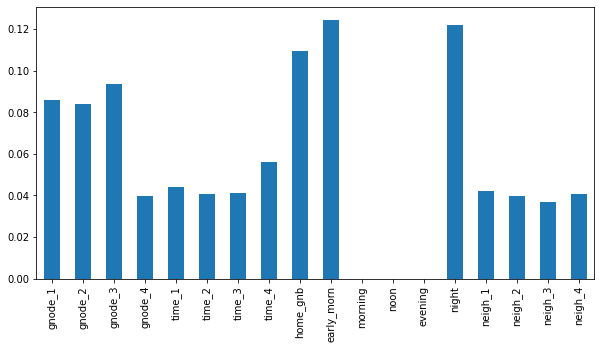

In [190]:
pd.Series(index=X_train.columns, data=importance).plot.bar()

In [191]:
y_pred = model.predict(X_train)

In [192]:
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 95.27032536899617,
 'predictionGnodeBAccuracy': 97.07929000516458,
 'predictionTimeSlotAccuracy': 97.32121014433662}

In [193]:
# Training Probabilities

In [194]:
probs = model.predict_proba(X_train)

In [195]:
gnb_preds = model.classes_[0][np.argsort(-probs[0])]
ts_preds = model.classes_[1][np.argsort(-probs[1])]

In [196]:
topk_accuracy(y_train.reset_index(), gnb_preds, ts_preds, k=1)
topk_accuracy(y_train.reset_index(), gnb_preds, ts_preds, k=3)
topk_accuracy(y_train.reset_index(), gnb_preds, ts_preds, k=5)

predictionAccuracy with first 1 results: 0.952689662670907
predictionAccuracy with first 3 results: 0.9999728179618907
predictionAccuracy with first 5 results: 1.0


1.0

The following class implements the very same data processing procedure used above. It's been compacted for convenience

In [197]:
class PreprocessData:
    def __init__(self, training_df,gnb_neigh):
        self.training_df = training_df
        self.gnb_neigh = gnb_neigh
    
    @staticmethod
    def window_sequence(seq, window_size=5):
        windows = []
        seq_len = len(seq)
        if seq_len < window_size:
            print(seq)
            padding_len = window_size - seq_len
        for i in range(len(seq) - window_size + 1):
            window = []
            for j in range(i, i + window_size):
                window.append(seq[j])
            windows.append(window)
        return windows

    def compute_home_gnb(self, grouped_df):
        ue_home_df = grouped_df.groupby(['imsi', 'currentEnb'])['stay_time'].sum().reset_index()
        home_gnb = ue_home_df.loc[ue_home_df.groupby(['imsi'])['stay_time'].idxmax()][['imsi', 'currentEnb']]
        home_gnb.columns = ['imsi', 'home_gnb']
        return home_gnb

    def compute_ue_context_df(self,grouped_df):
        grouped_df['time_of_day'] = pd.cut(grouped_df['timeSlot'], 
                                           bins=5,
                                           labels=['early_morn', 'morning', 'noon', 'evening', 'night'])
        ue_df = grouped_df.groupby(['imsi', 'time_of_day'])['currentEnb'].count().reset_index()
        ue_ctxt_df = pd.pivot_table(ue_df, index='imsi', columns='time_of_day', values='currentEnb', fill_value=0)
        return ue_ctxt_df

    def compute_transition_df(self, grouped_df):
        seq_df = grouped_df.groupby(['imsi'])['currentEnb', 'timeSlot','transition_slot'].agg(
            lambda x: list(x)).reset_index()
        seq_df['enode_seq'] = seq_df['currentEnb'].apply(self.window_sequence).values
        seq_df['time_seq'] = seq_df['timeSlot'].apply(self.window_sequence).values
        seq_df['trans_seq'] = seq_df['transition_slot'].apply(self.window_sequence).values
        enode_seq_list = [sequence for sequences in seq_df['enode_seq'] for sequence in sequences]
        time_seq_list = [sequence for sequences in seq_df['time_seq'] for sequence in sequences]
        trans_seq_list = [sequence for sequences in seq_df['trans_seq'] for sequence in sequences]
        seq_df['seq_len'] = seq_df['enode_seq'].apply(lambda x: len(x))
        imsi_list = list()
        for a, b in zip(seq_df['imsi'], seq_df['seq_len']):
            imsi_list.extend([a] * b)
        enode_df = pd.DataFrame(enode_seq_list, columns=['enode_1', 'enode_2', 'enode_3', 'enode_4', 'target_gnb'])
        #enode_df = pd.DataFrame(enode_seq_list, columns=['gnode_1', 'gnode_2', 'gnode_3', 'gnode_4', 'target_gnb'])
        time_df = pd.DataFrame(time_seq_list, columns=['time_1', 'time_2', 'time_3', 'time_4', 'target_time'])
        trans_df = pd.DataFrame(trans_seq_list, columns=['trans_1', 'trans_2', 'trans_3', 'trans_4', 'target_trans_slot'])
        df = pd.concat([enode_df, time_df], axis=1)
        #df = pd.concat([enode_df, time_df], axis=1)
        df['target_trans_slot'] = trans_df['target_trans_slot']
        df['imsi'] = imsi_list
        return df

    def preprocess_data(self):
        grouped_df = self.training_df.set_index(['imsi', 'timestamp']).sort_index().reset_index()
        grouped_df['next_timstamp'] = grouped_df.groupby(['imsi'])['timestamp'].shift(-1)
        grouped_df['prev_timstamp'] = grouped_df.groupby(['imsi'])['timestamp'].shift(1)
        grouped_df['stay_time'] = grouped_df['next_timstamp'] - grouped_df['timestamp']
        grouped_df['transit_time'] = grouped_df['timestamp'] - grouped_df['prev_timstamp']
        grouped_df['transition_slot'] = pd.cut(grouped_df['transit_time'], [0, 1, 5, 15, 30, 60, 3000],
                                               labels=[1, 5, 15, 30, 60, 100])

        home_gnb = self.compute_home_gnb(grouped_df)
        ue_ctxt_df = self.compute_ue_context_df(grouped_df)

        df = self.compute_transition_df(grouped_df)

        df = df.merge(home_gnb, on='imsi').merge(ue_ctxt_df, on='imsi')
        df = df.merge(self.gnb_neigh, left_on='enode_4', right_on='gnodeB', how='left')
        del df['gnodeB']
        df.dropna(inplace=True)
        y_train = df[['target_gnb', 'target_trans_slot']]

        to_drop_cols = ['target_gnb',
                        'target_trans_slot',
                        'target_time',
                        'imsi'
                       ]
        print(df.shape)
        df.drop(columns=to_drop_cols, inplace=True, axis=1)
        
        return df, y_train

In [198]:
#X_test = X_test2

In [199]:
day_2 = df.loc[(df['timestamp']>=1440) & (df['timestamp']<2880)]

preprocess_df = PreprocessData(day_2,gnb_neigh)
X_test, y_test = preprocess_df.preprocess_data()
y_pred = model.predict(X_test)

(65150, 22)


In [182]:
X_test.shape

(65150, 18)

In [183]:
y_test.shape

(65150, 2)

In [200]:
probs = model.predict_proba(X_test)
gnb_preds = model.classes_[0][np.argsort(-probs[0])]
ts_preds = model.classes_[1][np.argsort(-probs[1])]

In [201]:
topk_accuracy(y_test.reset_index(), gnb_preds, ts_preds, k=1)
topk_accuracy(y_test.reset_index(), gnb_preds, ts_preds, k=3)
topk_accuracy(y_test.reset_index(), gnb_preds, ts_preds, k=5)

predictionAccuracy with first 1 results: 0.8241135840368381
predictionAccuracy with first 3 results: 0.9961166538756715
predictionAccuracy with first 5 results: 0.9987106676899463


0.9987106676899463

In [202]:
accuracy = compute_accuracy(y_test, y_pred)
accuracy

{'predictionAccuracy': 82.40828856485034,
 'predictionGnodeBAccuracy': 88.40828856485035,
 'predictionTimeSlotAccuracy': 90.39293937068304}

## Model sharing
### Pickle file

In [142]:
import joblib

joblib.dump(model, 'mobility_model.pkl')

['mobility_model.pkl']

### ONNX

Open Neural Network Exchange (ONNX) is an open standard format for AI models, born initially with focus on deep learning, but eventually extended to traditional ML. It defines an extensible computation graph model, as well as definitions of built-in operators and standard data types so that it is possible to represent any arbitrary model.

It is possible for most of the popular ML frameworks to export trained models as ONNX models. For scikit-learn: [sklearn-onnx](http://onnx.ai/sklearn-onnx/). The converted ONNX model can be run by means of the [ONNX Runtime](https://www.onnxruntime.ai/) (thus enabling the creation of microservices).

In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import Int64TensorType

In [ ]:
X_train_onnx = X_train.to_numpy()
X_test_onnx = X_test.to_numpy()
y_train_onnx = y_train.to_numpy()
y_test_onnx = y_test.to_numpy()

In [ ]:
initial_type = [('input', Int64TensorType([None, 18]))]
onx = convert_sklearn(model, initial_types=initial_type, options={type(model): {'zipmap': False}})

In [ ]:
with open("mobility_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [ ]:
import onnxruntime as rt

In [ ]:
sess = rt.InferenceSession("mobility_model.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

In [ ]:
sess.run([label_name], {input_name: X_test_onnx[:1]})

[array([[13, 15]], dtype=int64)]

In [ ]:
model.predict(X_test_onnx[:1])

array([[13, 15]])

# Change Column Name - For Drifting purposes the column names of both sets should be called the same
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [160]:

X_test.rename(columns={'enode_1':'gnode_1', 'enode_2':'gnode_2', 'enode_3':'gnode_3', 
                       'enode_4':'gnode_4'}, inplace = True)



|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
# Let's check if there is datadrift
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [143]:
X_train.head(3)

,gnode_1,gnode_2,gnode_3,gnode_4,time_1,time_2,time_3,time_4,home_gnb,early_morn,morning,noon,evening,night,neigh_1,neigh_2,neigh_3,neigh_4
0,22,18,9,23,0,0,1,1,40,8,0,0,0,4,21,6,13,9
1,18,9,23,13,0,1,1,2,40,8,0,0,0,4,11,23,24,40
2,9,23,13,23,1,1,2,2,40,8,0,0,0,4,21,6,13,9


In [144]:
X_test.head(2)

,gnode_1,gnode_2,gnode_3,gnode_4,time_1,time_2,time_3,time_4,home_gnb,early_morn,morning,noon,evening,night,neigh_1,neigh_2,neigh_3,neigh_4
0,22,18,9,23,0,0,1,1,40,8,0,0,0,4,21,6,13,9
1,18,9,23,13,0,1,1,2,40,8,0,0,0,4,11,23,24,40


In [145]:
#!python --version

In [81]:
!pip uninstall scikit-learn
!pip install scikit-learn==0.23.1

Uninstalling scikit-learn-0.24.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-0.24.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-f7e03b3e.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-0.24.0
     |████████████████████████████████| 6.8MB 10.2MB/s 


In [73]:
!pip install pydrift

In [146]:
from pydrift import DataDriftChecker
from pydrift.constants import PATH_DATA, RANDOM_STATE

In [147]:
data_drift_checker_ok = DataDriftChecker(X_train, X_test)

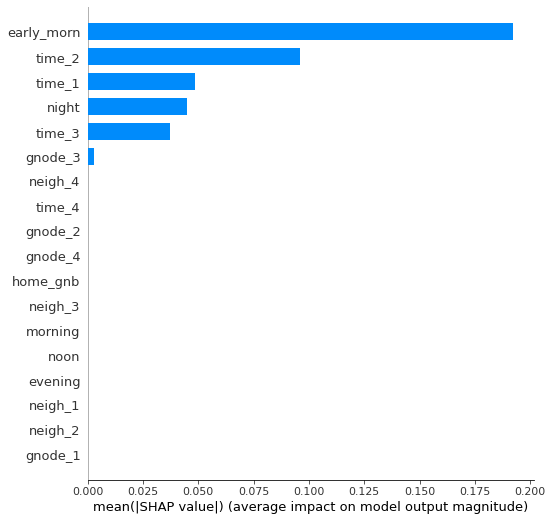

Drift found in discriminative model step, take a look on the most discriminative features (plots when minimal is set to False)

AUC drift check model: 0.61
AUC threshold: .5 ± 0.10


In [148]:
data_drift_checker_ok.ml_model_can_discriminate();

In [149]:
data_drift_checker_ok.check_numerical_columns();

Drift found in numerical columns check step, take a look on the variables that are drifted, if one is not important you could simply delete it, otherwise check the data source



/usr/local/lib/python3.7/dist-packages/pydrift/core/drift_checker.py:387: UserWarning:

Features drifted (numerical): gnode_1, gnode_2, time_1, time_2, time_3, time_4, early_morn, night, neigh_1, neigh_4



In [150]:
data_drift_checker_ok.check_categorical_columns();


No drift found in categorical columns check step



In [151]:
data_drift_checker_ok.drifted_features

{'early_morn',
 'gnode_1',
 'gnode_2',
 'neigh_1',
 'neigh_4',
 'night',
 'time_1',
 'time_2',
 'time_3',
 'time_4'}

In [152]:
X_train2 = X_train
X_test2 = X_test

# Dropping the drift columns (the important ones)

In [153]:
X_train2 = X_train2.drop(columns=['early_morn', 'time_2'])
X_test2 = X_test2.drop(columns=['early_morn', 'time_2'])

In [154]:
X_train2.shape

(73578, 16)

# Check we don't have drift


> No drift found in discriminative model step



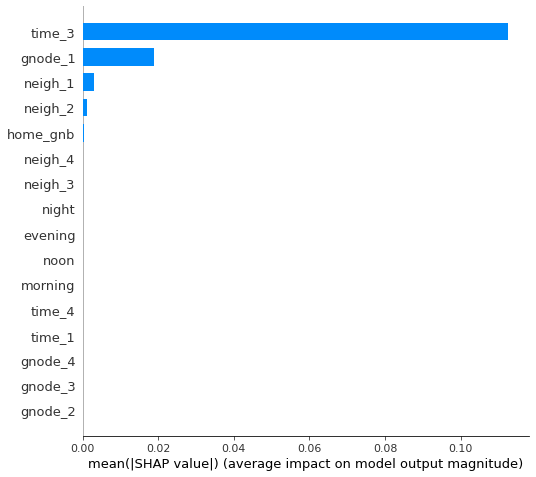

No drift found in discriminative model step

AUC drift check model: 0.54
AUC threshold: .5 ± 0.10


False

In [155]:
data_drift_checker_ok = DataDriftChecker(X_train2, X_test2)
data_drift_checker_ok.ml_model_can_discriminate()

# We run the model again

In [156]:
model = model.fit(X_train2, y_train)

y_pred = model.predict(X_test2)

In [157]:
accuracy = compute_accuracy(y_test, y_pred)
accuracy

{'predictionAccuracy': 85.02839600920952,
 'predictionGnodeBAccuracy': 90.18726016884114,
 'predictionTimeSlotAccuracy': 91.49654643131235}